In [1]:
import pandas as pd
from src.system import System
from src.sampler import MCMCSampler
from src.model import *
from src.priors import *
from src.results import *
import corner.corner as corner
import matplotlib.pyplot as plt

from WDPhotTools.fitter import WDfitter

In [8]:
df1_data = {'App Mag': [14.23, 14.10], 
            'Errors': [0.36, 0.39], 
            'Filter': ['K', 'H']}
df1 = pd.DataFrame(df1_data)
s = System(df1, 41.4741, 0.0211)

In [43]:
res = Results(s)
res.load_results("trial3-inf.hdf5")
flatchain = np.copy(res.post)
flatchain[:,1] *= 1e-9
labels = ['Mass [M$_{{\\odot}}$]', 'Age [Gyr]', 'Parallax [$\\frac{mas}{yr}$]']
flatchain.shape


(10000000, 3)

In [3]:
ftr = WDfitter()
ftr.fit(atmosphere=["H"],
        filters=["K_mko", "H_mko"],
        mags=[12.31651922, 12.19323903],
        mag_errors=[0.31652, 0.35052],
        distance=24.11,
        distance_err=0.012,
        extinction_convolved=False,
        Rv=0.0,
        independent=["Teff", "mass"],
        initial_guess=[5039.69, 0.895],
        method="emcee",
        nwalkers=200,
        nsteps=10000,
        nburns=100,
        progress=True,
        kwargs_for_CT={"tol": 1e-12}
        )


100%|██████████| 10000/10000 [03:12<00:00, 52.04it/s]


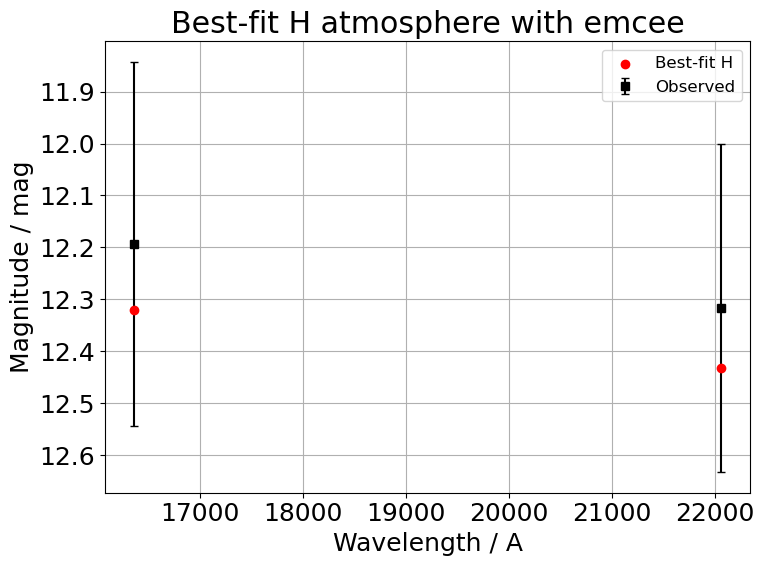

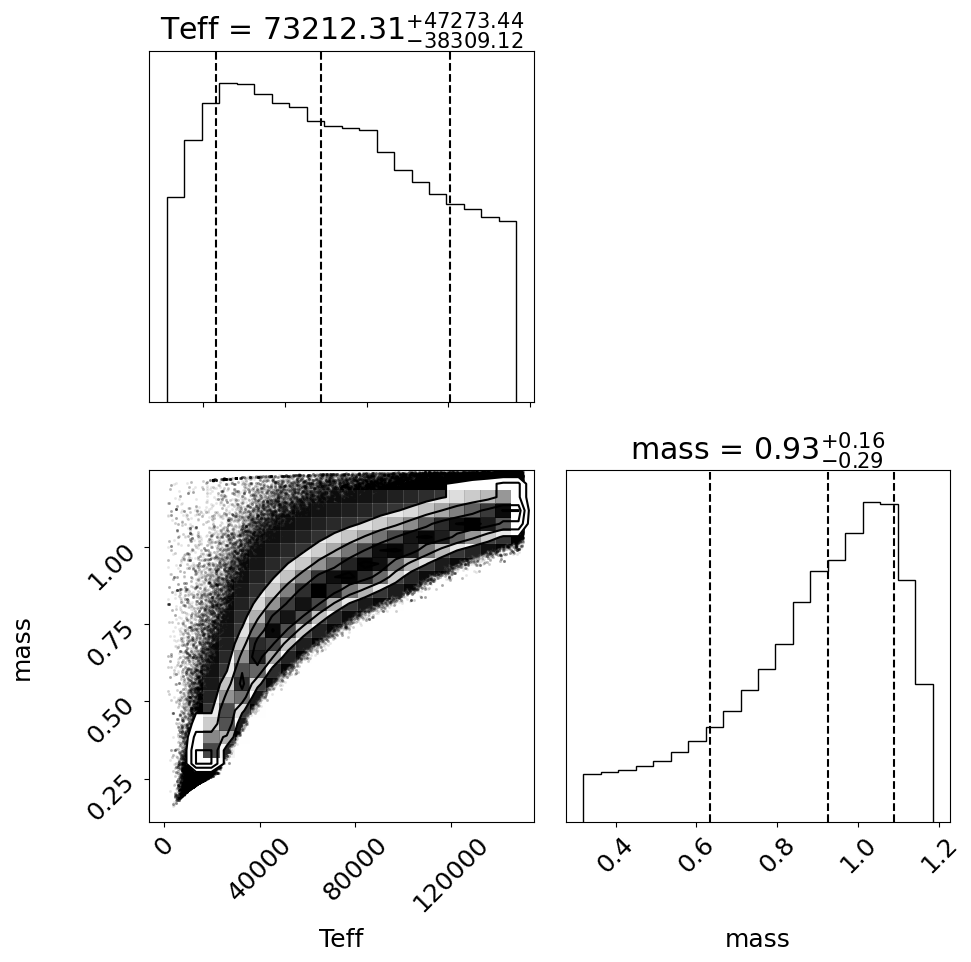

[<Figure size 1000x1000 with 4 Axes>]

In [4]:
ftr.best_fit_params
ftr.show_best_fit(display=False)
ftr.show_corner_plot(
    figsize=(10, 10),
    display=True,
    kwarg={
        "quantiles": [0.158655, 0.5, 0.841345],
        "show_titles": True,
    },
)

In [36]:
ftr.samples["H"].shape


(1980000, 2)

In [44]:
chain_coo = flatchain[10000000-1980000:]
chain_wdp = ftr.samples["H"][:,1]

In [45]:
chain_wdp = np.column_stack((chain_wdp, np.zeros((1980000,2))))

ValueError: It looks like the parameter(s) in column(s) 1, 2 have no dynamic range. Please provide a `range` argument.

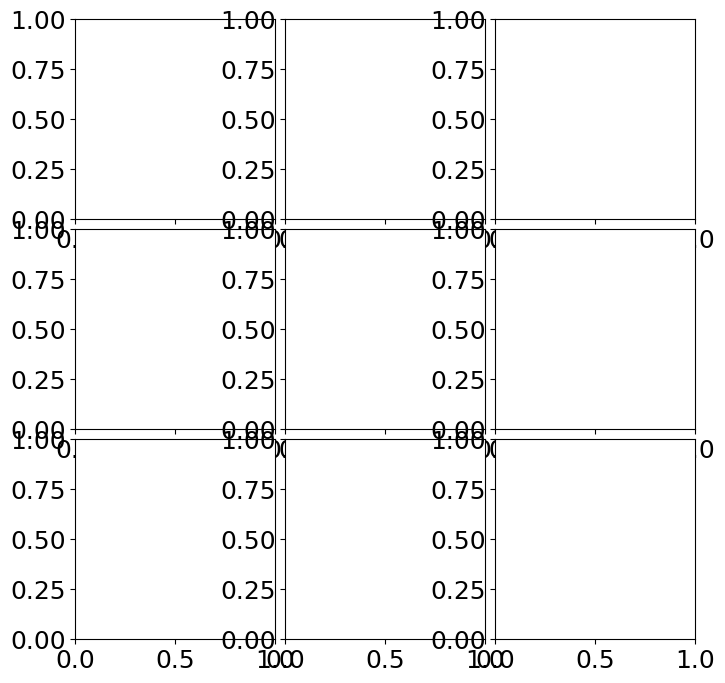

In [46]:
f1 = corner(chain_wdp, quantiles=[0.16,0.5,0.84], show_titles=True)
figure = corner(chain_coo, labels=labels, quantiles=[0.16,0.5,0.84], show_titles=True, fig=f1)